In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functorch
import matplotlib.pyplot as plt
import torch
from tqdm.auto import trange

from inv_benchmarks_torch.eggbox import EggboxProblem

In [3]:
problem = EggboxProblem(x_size=1, sigma_x0=1.0, sigma_n=0.3)
problem.init_sde()

# Choose true latent and observation
x = torch.tensor([0.1])
y = problem.transformation(x)

# True posterior for plotting below
x_grid = torch.linspace(-5, 5, 1000)[:, None]
log_posts = problem.get_log_post_t(0.0, x_grid, y)
posts = torch.exp(log_posts)
posts /= posts.sum() * (x_grid[1] - x_grid[0])

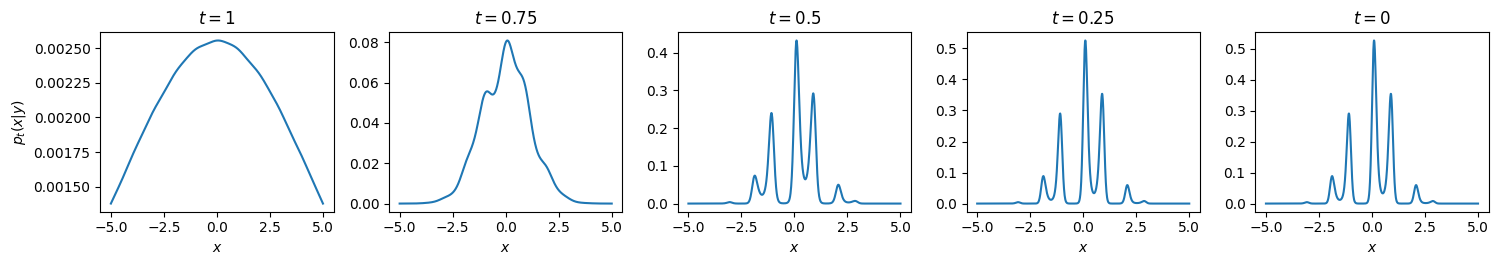

In [4]:
fig, axs = plt.subplots(1, 5, figsize=(15, 2.75))

for t, ax in zip(torch.linspace(1, 0, len(axs)), axs):
    log_posts = problem.get_log_post_t(t, x_grid, y)
    ax.plot(x_grid, torch.exp(log_posts))
    ax.set_xlabel(r"$x$")
    ax.set_title(r"$t = %g$" % t)

axs[0].set_ylabel(r"$p_t(x|y)$")

fig.tight_layout()

In [5]:
from torchtyping import patch_typeguard
from typeguard.importhook import install_import_hook

install_import_hook("pathint_torch")
patch_typeguard()

from pathint_torch import PathIntegralSampler
from pathint_torch.nn import ControlNet

In [7]:
# Set up pathint
get_log_mu = lambda x: problem.get_log_post_t(0.0, x, y)
T = 1.0
n_steps = 100
dt = T / n_steps
pathint = PathIntegralSampler(get_log_mu, 1, T, dt)

# Set up model
get_score_mu = functorch.vmap(lambda x: problem.get_score_post(x, y))
model = ControlNet(1, get_score_mu, T, 64, 64, [64, 64], [64, 64, 64])

# Set up training
opt = torch.optim.AdamW(model.parameters(), lr=2e-3)
batch_size = 128
n_steps = 100
losses = []
with trange(n_steps) as pbar:
    for _ in pbar:
        opt.zero_grad()
        loss = pathint.sample_loss(model, batch_size).mean()
        if torch.isnan(loss):
            print("nan loss")
            break
        loss.backward()
        opt.step()

        losses.append(loss.item())
        pbar.set_postfix(loss=losses[-1])

losses = torch.tensor(losses)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

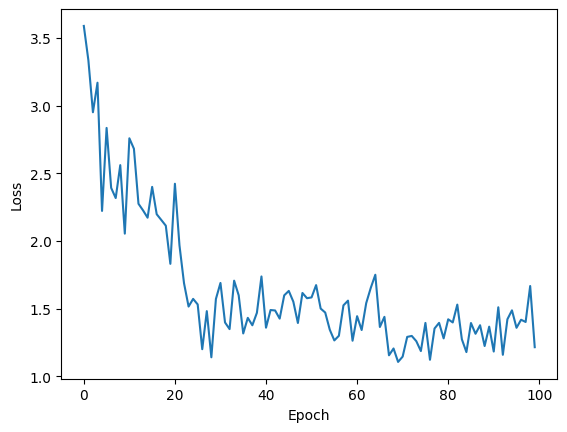

In [8]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [9]:
with torch.no_grad():
    xs, log_ws = pathint.sample(model, 10_000)
    xs = xs[-1, :, 0]

Text(0, 0.5, '$p(x|y)$')

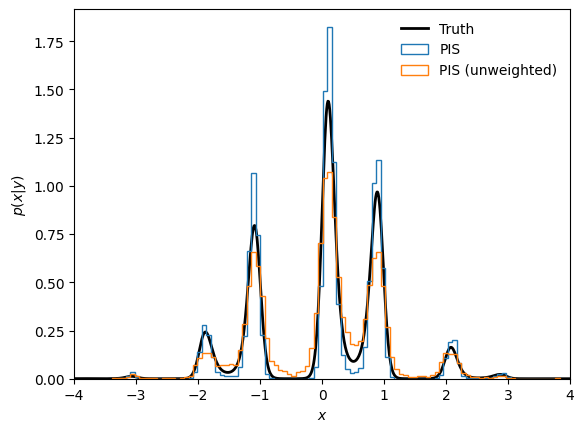

In [14]:
plt.plot(x_grid, posts, "k", lw=2, label="Truth")
plt.hist(xs, bins=100, histtype="step", density=True, weights=log_ws.exp(), label="PIS")
plt.hist(xs, bins=100, histtype="step", density=True, label="PIS (unweighted)")
plt.xlim(-4, 4)
plt.legend(frameon=False)
plt.xlabel(r"$x$")
plt.ylabel(r"$p(x|y)$")